# Restaurant Revenue Prediction
## 21239

## 1. Imports

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Load Data

In [119]:
data = pd.read_csv("./train.csv.zip")
data.head()


,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


## 3. Preprocess

In [120]:
df = pd.DataFrame()

In [121]:
df['ID'] = data['Id']
df['Open Date'] = pd.to_datetime(data['Open Date'])
df['Close'] = pd.DataFrame(['27/05/2023']*df.shape[0])
df['Close'] = pd.to_datetime(df['Close'],dayfirst=True)
df['Days'] = (df['Close']-df['Open Date'])
df["Days"] = df['Days'].apply(lambda i: i.days)
df['City'] = data['City']
df['City Group'] = data['City Group']
df['Type'] = data['Type']
df['Revenue'] = data['revenue']

In [122]:
df.head()

,ID,Open Date,Close,Days,City,City Group,Type,Revenue
0,0,1999-07-17,2023-05-27,8715,İstanbul,Big Cities,IL,5653753.0
1,1,2008-02-14,2023-05-27,5581,Ankara,Big Cities,FC,6923131.0
2,2,2013-03-09,2023-05-27,3731,Diyarbakır,Other,IL,2055379.0
3,3,2012-02-02,2023-05-27,4132,Tokat,Other,IL,2675511.0
4,4,2009-05-09,2023-05-27,5131,Gaziantep,Other,IL,4316715.0


In [123]:
df.drop(['ID','Open Date','Close'],axis = 1,inplace=True)

In [124]:
df.head()

,Days,City,City Group,Type,Revenue
0,8715,İstanbul,Big Cities,IL,5653753.0
1,5581,Ankara,Big Cities,FC,6923131.0
2,3731,Diyarbakır,Other,IL,2055379.0
3,4132,Tokat,Other,IL,2675511.0
4,5131,Gaziantep,Other,IL,4316715.0


In [125]:
df.isnull().any().any()

False

In [126]:
from sklearn.preprocessing import LabelEncoder as LE
encoder = LE()
columns = list(df.columns)
for column in columns:
    if df[column].dtypes == 'object':
        df[column] = encoder.fit_transform(df[column])

In [127]:
df.head()

,Days,City,City Group,Type,Revenue
0,8715,31,0,2,5653753.0
1,5581,3,0,1,6923131.0
2,3731,10,1,2,2055379.0
3,4132,28,1,2,2675511.0
4,5131,14,1,2,4316715.0


## 4. EDA

In [128]:
df.corr()

,Days,City,City Group,Type,Revenue
Days,1.000000,0.053452,-0.177907,0.061445,0.325821
City,0.053452,1.000000,-0.358040,0.061974,0.266076
City Group,-0.177907,-0.358040,1.000000,-0.098585,-0.237403
Type,0.061445,0.061974,-0.098585,1.000000,-0.090532
Revenue,0.325821,0.266076,-0.237403,-0.090532,1.000000


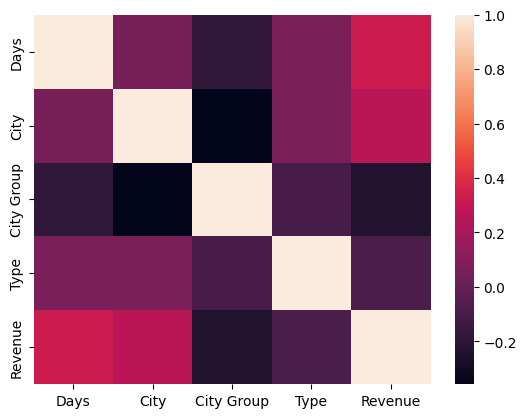

In [129]:
sns.heatmap(df.corr())
plt.show()

Inference: 
 - Days and City has high correlation with revenue
 - Since City Group also has high correlation since city has high correlation

We can use Days, City and City Group as our input variables.

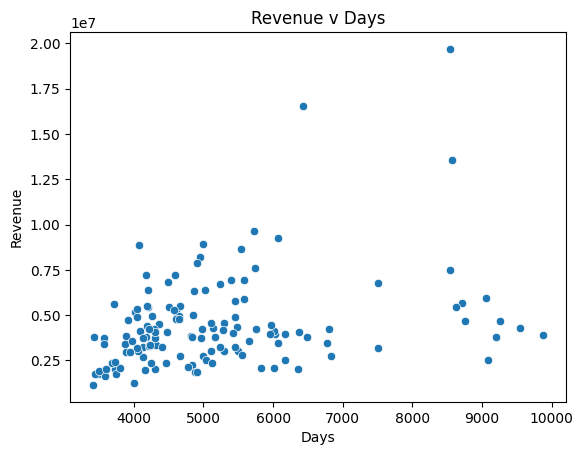

In [130]:
sns.scatterplot(x=df['Days'],y=df['Revenue']).set(title='Revenue v Days')
plt.show()

Inference:
 - There is no strong correlation between revenue and days which means implies that a simple linear model cant handle this data.

## 5. Model Building

### Linear Regression Model

In [175]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
lr_model = LinearRegression()
x = np.array(df['Days'])
y = np.array(df['Revenue'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
lr_model.fit(X_train,y_train)


LinearRegression()

In [180]:
print('Performance:\nTrain',lr_model.score(X_train,y_train),'\nTest:',lr_model.score(X_test,y_test))

Performance:
Train 0.07958903733383571 
Test: 0.12902649633084717


As expected the simple linear model is not able to fit the data

### Multiple linear regression

In [326]:
mlr_model = LinearRegression()
x = np.array(df.drop(['Revenue'],axis=1))
y = np.array(df['Revenue'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
X_train = X_train


mlr_model.fit(X_train,y_train)

LinearRegression()

In [225]:
print('Performance:\nTrain',mlr_model.score(X_train,y_train),'\nTest:',mlr_model.score(X_test,y_test))

Performance:
Train 0.1472636980650459 
Test: 0.22884552953864024


We can see almost 2x jump in the performance while using a multiple linear regression

### Polynomial Regression

In [347]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
degree=4
x = np.array(df['Days'])
y = np.array(df['Revenue'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
polyreg.fit(X_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=4)),
                ('linearregression', LinearRegression())])

In [319]:
print('Performance:\nTrain',polyreg.score(X_train,y_train),'\nTest:',polyreg.score(X_test,y_test))

Performance:
Train 0.1437660286676372 
Test: 0.18862515358845244


We can see a better performance while using polynomial regression with degree 4

### Decision Tree

In [331]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth=2)
dt.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=2)

In [332]:
print('Performance:\nTrain',dt.score(X_train,y_train),'\nTest:',dt.score(X_test,y_test))

Performance:
Train 0.22854686158416593 
Test: 0.17029733210223363


Decision tree with max depth 2 has a decent performance, trees with more depth is overfitting the data

### Random Forest

In [350]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=100, random_state=0)
forest.fit(X_train,y_train)

RandomForestRegressor(random_state=0)

In [351]:
print('Performance:\nTrain',forest.score(X_train,y_train),'\nTest:',forest.score(X_test,y_test))

Performance:
Train 0.8052304348663238 
Test: 0.3248415159379334


Out of every other model random forest performs best 

## 6. Results


| Model | Train | Test |
|---|---|---|---|---|
| Linear Regression | 7.95% | 12.90% |
| Multiple Linear Regression | 14.72% | 22.88% |
| Polynomial Regression | 14.27 |  18.86% |
| Decision Tree | 22.85% | 17.02% |
| Random Forest | 80.52 | 32.48% |
